# Funcionamiento de una red LSTM (función seno)

Antes de empezar a estudiar las series temporales desde sus orígines con las RNN (Redes neuronales recurrentes), vamos a ver cómo funciona la evolución de las RNN, las LSTM para ver cómo son capaces de entender la periodicidad dentro de una serie.

## Generación de los datos

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generar datos
n = 500
t = np.linspace(0,20.0*np.pi,n)
X = np.sin(t) # X está entre -1 y 1. No necesita normalización

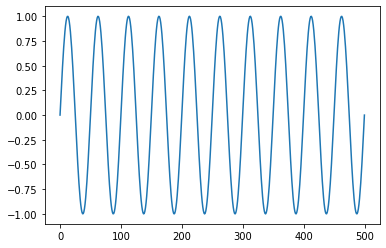

In [ ]:
plt.figure()
plt.plot(X)

## Preparación de los datos

In [ ]:
# Establecer la ventana de eventos pasados para el modelo LSTM (n. steps)
window = 10

# Dividir en train/test 80%/20%
last = int(n/5.0)
X_train = X[:-last]
X_test = X[-last-window:]

# Almacenar los números en la ventana como una secuencia
xin = []
next_X = []
for i in range(window,len(X_train)):
    xin.append(X_train[i-window:i])   # Los 10 valores anteriores
    next_X.append(X_train[i])         # El valor siguiente

# Reshape de los datos para la red LSTM
xin, next_X = np.array(xin), np.array(next_X)
xin = xin.reshape(xin.shape[0], xin.shape[1], 1) # Añadir 1 dimensión (si tuviéramos más características, pondríamos aquí el nº de variables)

Este sería el formato del array xin:

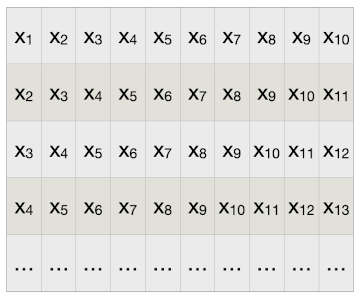

En next_X tenemos: $x_{11}, x_{12}, x_{13}, ...., x_{400}$

In [ ]:
xin.shape

(390, 10, 1)

In [ ]:
next_X.shape

(390,)

## Construcción del modelo LSTM

In [ ]:
xin.shape[1],1

(10, 1)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Initialize LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(xin.shape[1],1))) # Ponemos return_seq en las capas LSTM intermedias para pasar los valores h a la capa siguiente
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

## Entrenamiento del modelo

Epoch 1/50
8/8 [==============================] - 8s 6ms/step - loss: 0.4085
Epoch 2/50
8/8 [==============================] - 0s 5ms/step - loss: 0.2502
Epoch 3/50
8/8 [==============================] - 0s 6ms/step - loss: 0.2254
Epoch 4/50
8/8 [==============================] - 0s 6ms/step - loss: 0.1967
Epoch 5/50
8/8 [==============================] - 0s 6ms/step - loss: 0.1744
Epoch 6/50
8/8 [==============================] - 0s 6ms/step - loss: 0.1489
Epoch 7/50
8/8 [==============================] - 0s 5ms/step - loss: 0.1244
Epoch 8/50
8/8 [==============================] - 0s 6ms/step - loss: 0.0886
Epoch 9/50
8/8 [==============================] - 0s 6ms/step - loss: 0.0515
Epoch 10/50
8/8 [==============================] - 0s 6ms/step - loss: 0.0205
Epoch 11/50
8/8 [==============================] - 0s 6ms/step - loss: 0.0163
Epoch 12/50
8/8 [==============================] - 0s 5ms/step - loss: 0.0154
Epoch 13/50
8/8 [==============================] - 0s 5ms/step - loss: 0.

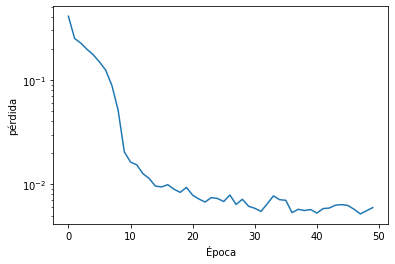

In [ ]:
# entrenar el modelop LSTM
history = model.fit(xin, next_X, epochs = 50, batch_size = 50,verbose=1)

plt.figure()
plt.ylabel('pérdida'); plt.xlabel('Época')
plt.semilogy(history.history['loss'])

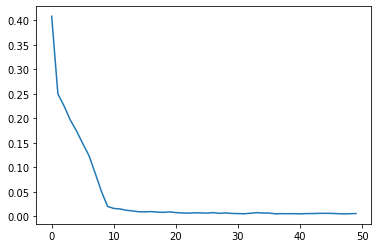

In [ ]:
plt.plot(history.history['loss'])

## Validación de la predicción de LSTM

La validación se realiza con el último 20% de los datos que se separó del 80% inicial de los datos.

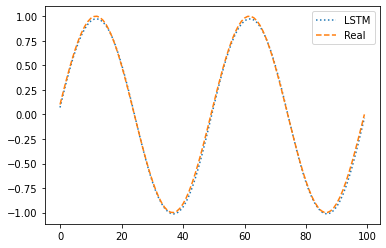

In [ ]:
# Almacenamos "window" valores como una secuencia
xin = []
next_X1 = []  # Los siguientes valores de cada secuencia
for i in range(window,len(X_test)):
    xin.append(X_test[i-window:i])
    next_X1.append(X_test[i])

# Reshape de los datos como array numpy para el LSTM
xin, next_X1 = np.array(xin), np.array(next_X1)
xin = xin.reshape((xin.shape[0], xin.shape[1], 1))

# Predecimos el siguiente valor (un paso por delante)
X_pred = model.predict(xin)

# Plot
plt.figure()
plt.plot(X_pred,':',label='LSTM')
plt.plot(next_X1,'--',label='Real')
plt.legend()

Esto no tiene mucho mérito, ya que el siguiente valor es fácil predecirlo tomando los 10 anteriores. Lo interesante es el siguiente apartado donde hacemos pronósticos a más largo plazo.

## Validación de pronósticos

Al realizar la validación, también es importante determinar cómo funciona el modelo cuando utiliza predicciones anteriores para predecir el próximo resultado. Esto es importante para determinar qué tan bien se desempeña el modelo en una aplicación predictiva.

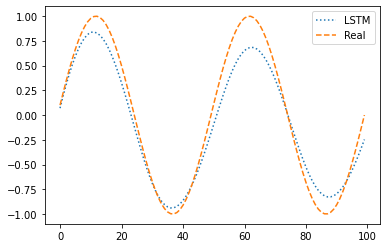

In [ ]:
# Usando los valores predichos para predecir el siguiente resultado
X_pred = X_test.copy()
for i in range(window,len(X_pred)):
    xin = X_pred[i-window:i].reshape((1, window, 1))
    X_pred[i] = model.predict(xin)

# Plot prediction vs actual for test data
plt.figure()
plt.plot(X_pred[window:],':',label='LSTM')
plt.plot(next_X1,'--',label='Real')
plt.legend()

# Series temporales



En primer lugar vamos a ver como podemos resolver el problema de predicción de series temporales haciendo uso de redes neuronales recurrentes RNN. 

Empezaremos por evaluar las RNN simples y, a continuación, trataremos de resolver el mismo problema con LSTM.

Para ello, vamos ahacer uso de una [base de datos](https://www.kaggle.com/c/web-traffic-time-series-forecasting/) que pemite predecir el número de accesos que tiene un artículo de Wikipedia. Esta base de datos cuenta con, aproximadamente, 145k series temporales. Cada serie temporal representa el número de visitas diaraias que ha recibido un artículo de Wikipedia desde el 1 de julio de 2015 hasta el 31 de diciembre de 2016.

In [ ]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
from datetime import datetime

from pandas import Series
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras 

import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install --upgrade --no-cache-dir gdown

In [ ]:
!gdown --id 1C0l3nZqBy7OUUMxXXzyspkzIbRRkqCdP

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1C0l3nZqBy7OUUMxXXzyspkzIbRRkqCdP
To: /content/train_1.csv
100% 278M/278M [00:02<00:00, 117MB/s]


In [ ]:
!ls

sample_data  train_1.csv


In [ ]:
# Leemos la base de datos

df = pd.read_csv('train_1.csv')

## Preparación de datos

In [ ]:
df

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145058,Underworld_(serie_de_películas)_es.wikipedia.o...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,13.0,12.0,13.0,3.0,5.0,10.0
145059,Resident_Evil:_Capítulo_Final_es.wikipedia.org...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
145060,Enamorándome_de_Ramón_es.wikipedia.org_all-acc...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
145061,Hasta_el_último_hombre_es.wikipedia.org_all-ac...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Eliminación de NaN

Vemos que las diferentes columnas contienen el número de accesos a una página web un día concreto. Hay registros diarios desde el 01/07/2015 al 31/12/2016 (1 año y 6 meses). 

In [ ]:
df.columns

Index(['Page', '2015-07-01', '2015-07-02', '2015-07-03', '2015-07-04',
       '2015-07-05', '2015-07-06', '2015-07-07', '2015-07-08', '2015-07-09',
       ...
       '2016-12-22', '2016-12-23', '2016-12-24', '2016-12-25', '2016-12-26',
       '2016-12-27', '2016-12-28', '2016-12-29', '2016-12-30', '2016-12-31'],
      dtype='object', length=551)

De la información del DataFrame vemos que para algunas páginas tenemos registros desconocidos (NaN), estos registros vamos a eliminarlos.

In [ ]:
# Eliminamos registros en los que tenemos valores nulos
new_df = df.dropna()

In [ ]:
new_df.shape

(117277, 551)

In [ ]:
new_df

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
5,5566_zh.wikipedia.org_all-access_spider,12.0,7.0,4.0,5.0,20.0,8.0,5.0,17.0,24.0,...,16.0,27.0,8.0,17.0,32.0,19.0,23.0,17.0,17.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144944,Chichén_Itzá_es.wikipedia.org_all-access_spider,8.0,13.0,19.0,14.0,6.0,5.0,10.0,9.0,5.0,...,15.0,18.0,12.0,6.0,5.0,14.0,10.0,174.0,8.0,19.0
144945,Fecundación_es.wikipedia.org_all-access_spider,29.0,16.0,6.0,11.0,33.0,4.0,11.0,16.0,10.0,...,8.0,8.0,13.0,3.0,6.0,10.0,16.0,10.0,7.0,8.0
144946,Gran_Hermano_VIP_(España)_es.wikipedia.org_all...,4.0,25.0,7.0,11.0,6.0,6.0,16.0,11.0,23.0,...,12.0,299.0,46.0,5.0,11.0,77.0,523.0,110.0,171.0,43.0
144947,Modelo_atómico_de_Thomson_es.wikipedia.org_all...,0.0,2.0,6.0,6.0,7.0,5.0,4.0,6.0,7.0,...,13.0,1.0,5.0,11.0,9.0,11.0,6.0,7.0,9.0,4.0


In [ ]:
# Reestablecemos índices filas (sino se mantienen índices originales)
new_df = new_df.reset_index().drop(['index'], axis=1)
new_df

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,5566_zh.wikipedia.org_all-access_spider,12.0,7.0,4.0,5.0,20.0,8.0,5.0,17.0,24.0,...,16.0,27.0,8.0,17.0,32.0,19.0,23.0,17.0,17.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117272,Chichén_Itzá_es.wikipedia.org_all-access_spider,8.0,13.0,19.0,14.0,6.0,5.0,10.0,9.0,5.0,...,15.0,18.0,12.0,6.0,5.0,14.0,10.0,174.0,8.0,19.0
117273,Fecundación_es.wikipedia.org_all-access_spider,29.0,16.0,6.0,11.0,33.0,4.0,11.0,16.0,10.0,...,8.0,8.0,13.0,3.0,6.0,10.0,16.0,10.0,7.0,8.0
117274,Gran_Hermano_VIP_(España)_es.wikipedia.org_all...,4.0,25.0,7.0,11.0,6.0,6.0,16.0,11.0,23.0,...,12.0,299.0,46.0,5.0,11.0,77.0,523.0,110.0,171.0,43.0
117275,Modelo_atómico_de_Thomson_es.wikipedia.org_all...,0.0,2.0,6.0,6.0,7.0,5.0,4.0,6.0,7.0,...,13.0,1.0,5.0,11.0,9.0,11.0,6.0,7.0,9.0,4.0


### Reorganización de columnas

In [ ]:
# Hacemos una copia del DataFrame ya que le vamos a aplicar más transformaciones (no se usa?)
new_df_copy = new_df.copy()

In [ ]:
# Eliminamos la columna Page ya que no es relevante para el modelo
new_df = new_df.drop(['Page'], axis=1)

In [ ]:
# Visualizamos 10 primeros registros
new_df.head(10)

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,24.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,4.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,16.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,12.0,7.0,4.0,5.0,20.0,8.0,5.0,17.0,24.0,7.0,...,16.0,27.0,8.0,17.0,32.0,19.0,23.0,17.0,17.0,50.0
5,118.0,26.0,30.0,24.0,29.0,127.0,53.0,37.0,20.0,32.0,...,64.0,35.0,35.0,28.0,20.0,23.0,32.0,39.0,32.0,17.0
6,5.0,23.0,14.0,12.0,9.0,9.0,35.0,15.0,14.0,22.0,...,34.0,105.0,72.0,36.0,33.0,30.0,36.0,38.0,31.0,97.0
7,6.0,3.0,5.0,12.0,6.0,5.0,4.0,13.0,9.0,15.0,...,25.0,17.0,22.0,29.0,30.0,29.0,35.0,44.0,26.0,41.0
8,2.0,1.0,4.0,4.0,2.0,6.0,3.0,6.0,9.0,11.0,...,8.0,17.0,18.0,48.0,19.0,14.0,9.0,23.0,11.0,7.0
9,2.0,5.0,5.0,1.0,3.0,3.0,5.0,3.0,17.0,3.0,...,5.0,4.0,4.0,5.0,2.0,9.0,7.0,4.0,5.0,0.0


In [ ]:
# Vamos a cambiar los nombre de las columnas por instantes temporales (0, 1, ...) para facilitar su posterior uso
new_df.columns = [ i for i,x in enumerate(new_df.columns)]
    
new_df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,540,541,542,543,544,545,546,547,548,549
0,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,24.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,4.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,16.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,12.0,7.0,4.0,5.0,20.0,8.0,5.0,17.0,24.0,7.0,...,16.0,27.0,8.0,17.0,32.0,19.0,23.0,17.0,17.0,50.0
5,118.0,26.0,30.0,24.0,29.0,127.0,53.0,37.0,20.0,32.0,...,64.0,35.0,35.0,28.0,20.0,23.0,32.0,39.0,32.0,17.0
6,5.0,23.0,14.0,12.0,9.0,9.0,35.0,15.0,14.0,22.0,...,34.0,105.0,72.0,36.0,33.0,30.0,36.0,38.0,31.0,97.0
7,6.0,3.0,5.0,12.0,6.0,5.0,4.0,13.0,9.0,15.0,...,25.0,17.0,22.0,29.0,30.0,29.0,35.0,44.0,26.0,41.0
8,2.0,1.0,4.0,4.0,2.0,6.0,3.0,6.0,9.0,11.0,...,8.0,17.0,18.0,48.0,19.0,14.0,9.0,23.0,11.0,7.0
9,2.0,5.0,5.0,1.0,3.0,3.0,5.0,3.0,17.0,3.0,...,5.0,4.0,4.0,5.0,2.0,9.0,7.0,4.0,5.0,0.0


In [ ]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117277 entries, 0 to 117276
Columns: 550 entries, 0 to 549
dtypes: float64(550)
memory usage: 492.1 MB


### Preparación de datos para análisis de series temporales

Para entrenar el modelo tenemos que definir el número de instantes temporales que vamos a introducir al modelo como entrada.
Así la RNN tiene que recibir una matriz 3D con las siguientes dimensiones: 

[tamaño lote, nº de instantes temporales, nº de características en un instante temporal].

[117273, 160, 1]

Por lo tanto, vamos a crear dicha matriz:

In [ ]:
num_steps = 160 # Número de instantes temporales

master_series = []

# Recorremos todos los registros
for i in range(len(new_df)):
    
    ### No empleamos registros que tengan todos sus valores a 0 (=desconocido)
    if (max(new_df.iloc[i, 0:num_steps]) == 0 ):
        continue
      
    # De cada serie temporal seleccionamos los primeros 160 instantes temporales
    myseries = np.array(new_df.iloc[i][0:num_steps])
    master_series.append(myseries)
    
master_series = np.array(master_series)

# añadimos una dimensión porque sólo usamos una variable: número de visitas en un día
master_series = master_series[..., np.newaxis].astype(np.float32)

('Tamaño base de datos: ', master_series.shape)

('Tamaño base de datos: ', (117273, 160, 1))

Vemos que hemos perdido 4 registros tras eliminar aquellos con todos los registros a 0 (hemos pasado de 117277 a 117273)

### Eliminación de Outliers

Ahora vamos a ver si tenemos valores atípicos (outliers) y, en tal caso, eliminarlos de la base de datos.

Para ello vamos a calcular los percentiles 1, 5, 95, 99, así como los valores mínimo y máximo de la base de datos. 

In [ ]:
# Convertimos matriz a vector
master_series_values = master_series.reshape(-1,1)

# Percentiles
print(np.percentile(master_series_values, [1, 5, 95, 99]))
# Mínimo
print(master_series_values.min())
# Máximo
print(master_series_values.max())

[1.000e+00 3.000e+00 3.322e+03 9.883e+03]
0.0
27562968.0


Del análisis anterior se puede observar que hay valores muy altos en nuestra base de datos. Esto se observa porque el percentil 99 tiene un valor de 9883, sin embargo, el valor máximo es muy superior, por lo tanto, estos registros por encima del percentil 99 se pueden considerar valores atípicos.

De este modo, vamos a dejar únicamente los registros con valores inferiores o iguales al percentil 99.

In [ ]:
perc_99 = np.percentile(master_series_values,99)

### Mantenemos únicamente los registros con valores inferiores al percentil 99

master_wo_outliers = [master_series[i] for i in range(0, master_series.shape[0]) \
                      if (max(master_series[i,:]) <= perc_99)]

### Convertimos lista a vector
master_wo_outliers = np.array(master_wo_outliers)

print('Tamaño matriz antes de eliminar valores atípicos:', master_series.shape)
print('Tamaño matriz tras eliminar valores atípicos:', master_wo_outliers.shape)

### Calculamos percentil 99 y valor máximo del nuevo dataset
print(np.percentile(master_wo_outliers, 99))
print(master_wo_outliers.max())

Tamaño matriz antes de eliminar valores atípicos: (117273, 160, 1)
Tamaño matriz tras eliminar valores atípicos: (102220, 160, 1)
3668.0
9882.0


Podemos observar que ya no tenemos valores atípicos (ya no hay tanta diferencia entre el percentil 99 y el valor máximo).

En este paso hemos eliminado 15053 registros con valores atípicos.

In [ ]:
# Creamos copia bases de datos antes y después de eliminar los valores atípicos (no se usan?)
master_series_orig = master_series.copy()
master_wo_outliers_copy = master_wo_outliers.copy()

In [ ]:
master_series = master_wo_outliers

### Valores logarítmicos

In [ ]:
# Fijamos semilla aleatoria para tener todos los mismos resultados
np.random.seed(42)
# Mezclamos el dataset
np.random.shuffle(master_series)

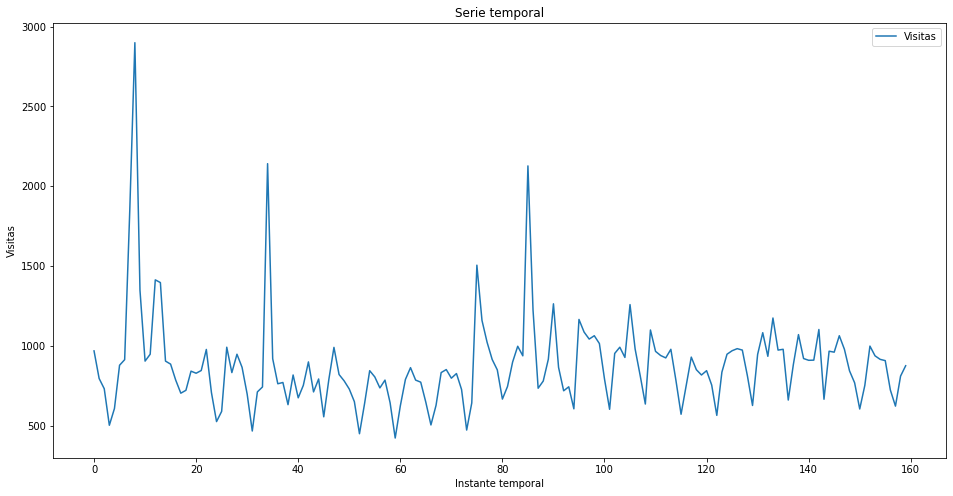

In [ ]:
# Mostramos la serie temporal de una muestra dada

plt.figure(figsize=(16,8))
sample = 200

plt.plot(master_series[sample,:], label = 'Visitas')
plt.title('Serie temporal')
plt.xlabel("Instante temporal")
plt.ylabel("Visitas")
plt.legend(loc = 'best')

Se observa que el rango de la serie temporal es muy grande. Para disminuir este rango vamos a escalar los registros mediante una transformación logarítmica.

In [ ]:
log_master_series = []

for i in range(master_series.shape[0]):
    
    # Hay muchos instantes con valor 0 en la base de datos. Para tratar bien con estos vamos a sumarle 1 a todos los registros
    # Esto lo deberemos de tener en cuenta a posteriori, en el momento de inferencia, al deshacer la transformación aplicada
    temp_series = np.array(np.log(master_series[i][0:] + 1))
    log_master_series.append(temp_series)
    
log_master_series = np.array(log_master_series) 

# Vemos algunos registros
print(log_master_series[0,:10])

[[1.3862944]
 [1.0986123]
 [2.8332133]
 [2.4849067]
 [1.9459102]
 [2.6390574]
 [2.7725887]
 [1.609438 ]
 [1.9459102]
 [2.0794415]]


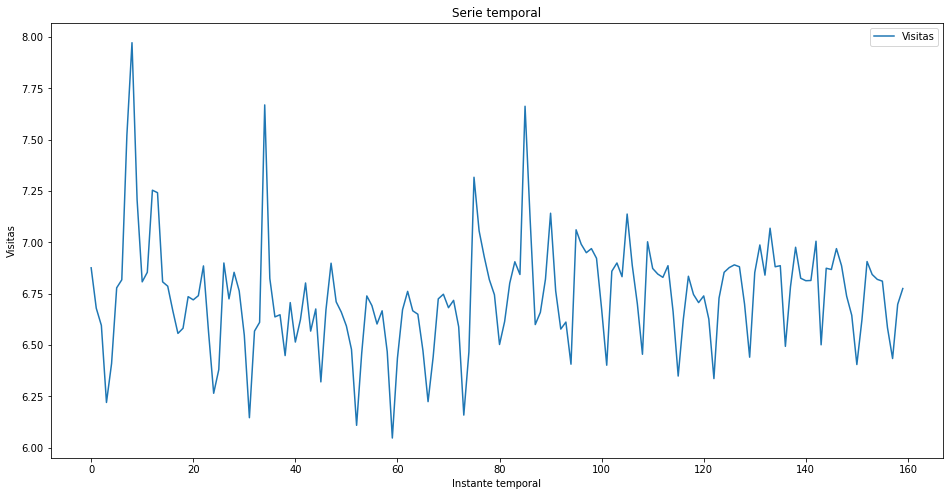

In [ ]:
# Mostramos el mismo registro que antes tras aplicar transformación logarítmica
plt.figure(figsize=(16,8))
sample = 200

plt.plot(log_master_series[sample,:], label = 'Visitas')
plt.title('Serie temporal')
plt.xlabel("Instante temporal")
plt.ylabel("Visitas")
plt.legend(loc = 'best')

Vemos que el rango se ha reducido considerablemente.

### Train, validation, test

En este punto vamos a crear las bases de datos de entrenamiento, validación y test. Para todas ellas vamos a emplear 150 registros para entrenar y vamos a tratar de predecir un instante temporal, es decir, el instante temporal 151.

Para ello vamos a emplear 70.000 registros para entrenar, 20.000 para validar y 10.000 para testear.

In [ ]:
log_master_series.shape

(102220, 160, 1)

In [ ]:
np.random.seed(42)

# Número instante temporales "conocidos"
n_steps = 150

# Instante temporal a predecir
predicted_day = n_steps + 1

# Entrenamiento
X_train, y_train = log_master_series[:70000, :n_steps], log_master_series[:70000, n_steps]
# Validación
X_valid, y_valid = log_master_series[70000:90000, :n_steps], log_master_series[70000:90000, n_steps]
# Test
X_test, y_test = log_master_series[90000:100000, :n_steps], log_master_series[90000:100000, n_steps]

In [ ]:
print('Datos entrada entrenamiento:', X_train.shape)
print('Datos salida entrenamiento:', y_train.shape)

print('Datos entrada validación:', X_valid.shape)
print('Datos salida validación:', y_valid.shape)

print('Datos entrada test:', X_test.shape)
print('Datos salida test:', y_test.shape)

Datos entrada entrenamiento: (70000, 150, 1)
Datos salida entrenamiento: (70000, 1)
Datos entrada validación: (20000, 150, 1)
Datos salida validación: (20000, 1)
Datos entrada test: (10000, 150, 1)
Datos salida test: (10000, 1)


Vamos a tratar de entender las dimensiones de las matrices que hemos generado.

X_train:
* 70.000 - Número de registros.
* 150 - Número de instantes temporales empleados para entrenar (instantes temporales conocidos).
* 1 - Número de valores (sólo vamos a emplear una variable, esto es, el número de visitas en un día).

y_train:

* 70000 - Número de registros.
* 1 - Número de instantes temporales a predecir.

Finalmente, vamos a normalizar los registros para que se encuentren en un rango entre 0-1. 

Para ello vamos a hacer uso del método MinMaxScaler de scikit-learn y vamos a ajustarlo con los datos de entrenamiento. Una vez ajustado, lo emplearemos para normalizar las 3 bases de datos (entrenamiento, validación y test).

In [ ]:
X_train.reshape(-1, 1).shape

(10500000, 1)

In [ ]:
# Normalización entre 0-1

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Ajustamos normalizador con los datos de entrenamiento y los transformamos
X_train_values = X_train.reshape(-1, 1) # Convertimos a vector
X_train_normalized = scaler.fit_transform(X_train_values)

# Transformamos datos entrenamiento
y_train_normalized = scaler.transform(y_train)


# Transformamos datos validación
X_valid_values = X_valid.reshape(-1, 1)
X_valid_normalized = scaler.transform(X_valid_values)
y_valid_normalized = scaler.transform(y_valid)


# Transformamos datos test
X_test_values = X_test.reshape(-1, 1)
X_test_normalized = scaler.transform(X_test_values)
y_test_normalized = scaler.transform(y_test)


# Redimensionamos las matrices para que vuelvan al tamaño deseado (3D)
X_train = X_train_normalized.reshape(X_train.shape[0] , X_train.shape[1] , X_train.shape[2])
X_valid = X_valid_normalized.reshape(X_valid.shape[0] ,X_valid.shape[1] , X_valid.shape[2])
X_test = X_test_normalized.reshape(X_test.shape[0] ,X_test.shape[1] , X_test.shape[2])

y_train = y_train_normalized.reshape(y_train.shape[0], y_train.shape[1] )
y_valid = y_valid_normalized.reshape(y_valid.shape[0], y_valid.shape[1] )
y_test =  y_test_normalized.reshape(y_test.shape[0], y_test.shape[1] )

# Comprobamos dimensiones matrices
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((70000, 150, 1),
 (70000, 1),
 (20000, 150, 1),
 (20000, 1),
 (10000, 150, 1),
 (10000, 1))

In [ ]:
print('Rango datos entrada entrenamiento:', X_train.min(), '-', X_train.max())
print('Rango datos salida entrenamiento:', y_train.min(), '-', y_train.max())

print('Rango datos entrada validación:', X_valid.min(), '-', X_valid.max())
print('Rango datos salida validación:', y_valid.min(), '-', y_valid.max())

print('Rango datos entrada test:', X_test.min(), '-', X_test.max())
print('Rango datos salida test:', y_test.min(), '-', y_test.max())

Rango datos entrada entrenamiento: 0.0 - 1.0
Rango datos salida entrenamiento: 0.0 - 0.9984713
Rango datos entrada validación: 0.0 - 0.9999451
Rango datos salida validación: 0.0 - 0.99031955
Rango datos entrada test: 0.0 - 0.99998903
Rango datos salida test: 0.0 - 0.9781296


In [ ]:
# Vamos a crear un método para deshacer las transformaciones que hemos aplicado para que se encuentren en el rango original

def reverse_transform(arr):
    
    arr = arr.reshape(-1,1)
    
    # Deshacemos escalado MinMax
    arr_inv_normal = scaler.inverse_transform(arr)
    
    # Deshacemos transformación logarítmica y restamos 1 (del que hemos sumando antes)
    arr_reverse = np.exp(arr_inv_normal ) - 1
    return (arr_reverse)

### Visualización

In [ ]:
# Método para mostrar serie temporal 
def plot_series(series, y=None, y_pred=None, lag=n_steps, x_label="Instante temporal", y_label="Valor"):
    
    plt.figure(figsize=(14,7))
    plt.plot(np.arange(n_steps-lag, n_steps), series, ".-")
    
    if y is not None:
        # Salida real
        plt.plot(n_steps, y, "bX", markersize=10)
        
    if y_pred is not None:
        # Salida predicha
        plt.plot(n_steps, y_pred, "ro")
        
    plt.grid(True)
    
    if x_label:
        plt.xlabel(x_label, fontsize=12)
    if y_label:
        plt.ylabel(y_label, fontsize=12, rotation=90)
    
    
    plt.axis([n_steps-lag, n_steps+1 , 0, 1])
    plt.xticks(np.arange(n_steps-lag, n_steps+1, 1))
    plt.yticks(np.arange(0, 1, 0.1))



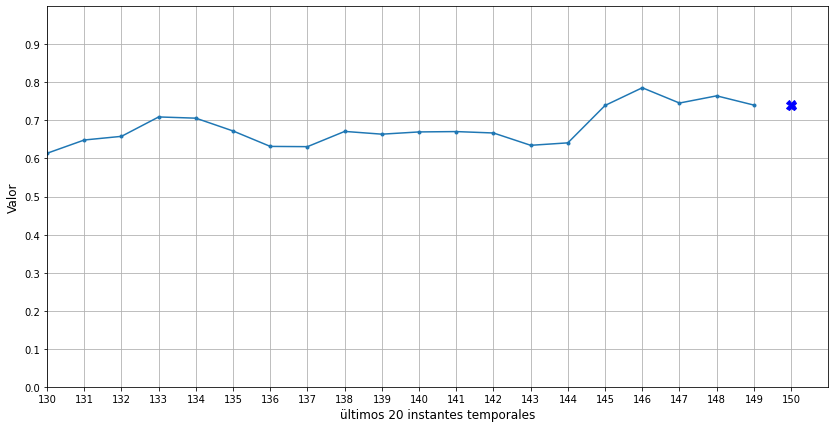

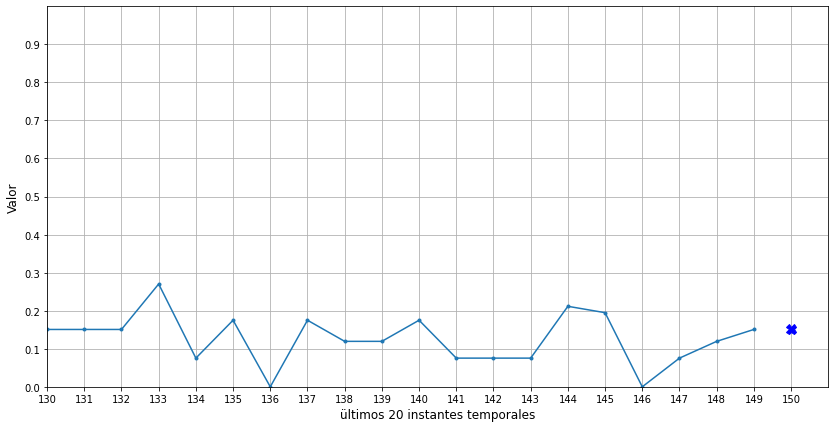

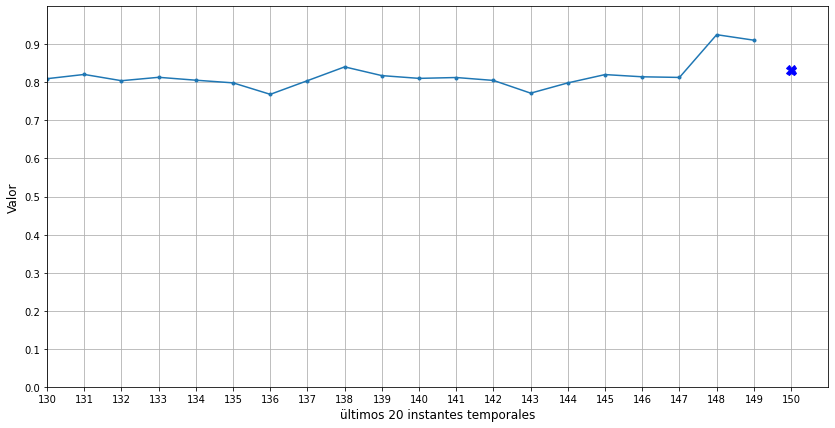

In [ ]:
# Mostramos 20 últimos instantes temporales de 3 registros de validación
for i in range(3):
    plot_series(X_valid[i, n_steps-20 : , 0], y_valid[i, 0],
                lag=20, x_label="ültimos 20 instantes temporales", y_label=("Valor"))
    
plt.show()

## RNN Simple

En primer lugar vamos a implementar una arquitectura sencilla con una RNN simple.

In [ ]:
# Fijamos semillas numpy y Tensorflow para obtener los mismos resultados (para experimentos reales esto no usarlo)
np.random.seed(42)
tf.random.set_seed(42)

# Definimos arquitectura
simp_rnn_model = keras.models.Sequential([
        keras.layers.SimpleRNN(1, input_shape=[None, 1]) #### RNN con una única neurona
])

simp_rnn_model.summary()

# Tasa de aprendizeja
optimizer = keras.optimizers.Adam(lr=0.0001)

# Compilamos. Función de coste MSE (regresión)
simp_rnn_model.compile(loss="mse", optimizer=optimizer)

# Paramos entrenamiento si no hay mejora en validación en las últimas 5 épocas
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001, verbose=1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


NOTA: El entrenamiento es largo (3.5 min por época aprox.) para primeros experimentos podéis probar dividiendo la base de datos de entrenamiento a la mitad.

In [ ]:
# Entrenamiento
history_srnn = simp_rnn_model.fit(X_train, y_train, epochs=50, batch_size=32,
                    validation_data=(X_valid, y_valid), callbacks=[early_stopping])

Epoch 1/50
2188/2188 [==============================] - 230s 105ms/step - loss: 0.0257 - val_loss: 0.0077
Epoch 2/50
2188/2188 [==============================] - 226s 103ms/step - loss: 0.0062 - val_loss: 0.0056
Epoch 3/50
2188/2188 [==============================] - 225s 103ms/step - loss: 0.0055 - val_loss: 0.0052
Epoch 4/50
2188/2188 [==============================] - 224s 102ms/step - loss: 0.0052 - val_loss: 0.0049
Epoch 5/50
1681/2188 [======================>.......] - ETA: 50s - loss: 0.0049

In [ ]:
simp_rnn_model.save('srnn.h5')
history_df = pd.DataFrame(simp_rnn_model.history.history)
history_df.to_csv('srnn.history.csv')

In [ ]:
# Visualizamos curvas de aprendizaje
import matplotlib
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)), loss, "b.-", label="Pérdidas entrenamiento")
    plt.plot(np.arange(len(val_loss)), val_loss, "r.-", label="Pérdidas validación")
    plt.gca().xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
    plt.legend(fontsize=14)
    plt.xlabel("Época")
    plt.ylabel("Pérdidas (MSE)")
    plt.grid(True)

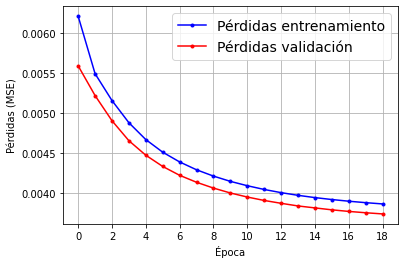

In [ ]:
plot_learning_curves(history_srnn.history["loss"][1:], history_srnn.history["val_loss"][1:])
plt.show()

In [ ]:
# Evaluamos modelos sobre el set de test
simp_rnn_mse = simp_rnn_model.evaluate(X_test, y_test, verbose=0)
print('MSE test RNN simple:', simp_rnn_mse)

MSE test RNN simple: 0.003814787371084094


In [ ]:
# Método para mostrar predicción de un instante temporal

def plot_single_prediction(series, y, y_pred, sample, lag = n_steps, x_label = "Instante temporal", y_label = "Valor"):

    plt.figure(figsize=(16,8))

    plt.plot(np.arange(n_steps - lag, n_steps), series, ".-", label = 'Últimas ' + str(lag) + ' visitas')
    plt.plot(n_steps, y, "ro", label = 'Real = ' + str(y[0,0]))
    plt.plot(n_steps, y_pred, "gx",  label = 'Predicción = '+ str(y_pred[0,0]))
    plt.xticks(np.arange(n_steps - lag, n_steps + 1, 1))
    
    plt.title('Número de visitas predichas para muestra ' + str(sample) + \
              ', en el día ' + str(n_steps + 1))

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(loc = 'best')

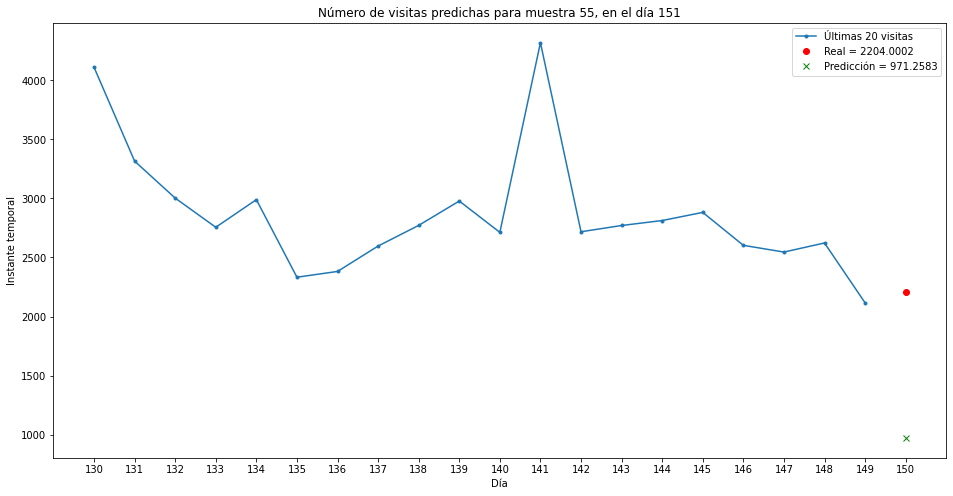

In [ ]:
y_pred_srnn = simp_rnn_model.predict(X_test)

# Visualizamos predicción de un caso de test (registro 55)
sample=55
lag=20

plot_single_prediction(reverse_transform(X_test[sample, n_steps - lag : , 0]), \
                       reverse_transform(y_test[sample]), reverse_transform(y_pred_srnn[sample]), \
                       sample = sample, lag = lag, x_label = "Día", y_label = "Instante temporal")

Vemos que hay error en la predicción con el modelo anterior. Vamos a construir un RNN más profunda y más unidades.

## RNN Profunda

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

# Definimos la arquitectura
d_rnn_model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.Dropout(rate=0.2),   ### Esta capa de Dropout hace que las pérdidas en validación no fluctúen mucho
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)      
])

# Tasa de aprendizaje
optimizer = keras.optimizers.Adam(lr=0.0001)
# Compilamos
d_rnn_model.compile(loss="mse", optimizer=optimizer)

d_rnn_model.summary()

#Paramos entrenamiento si no hay mejora en validación en las últimas 5 épocas
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
# Guardamos pesos modelo que genere las menores pérdidas en validación
mc = keras.callbacks.ModelCheckpoint('best_model_drnn.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, None, 20)          440       
                                                                 
 dropout_1 (Dropout)         (None, None, 20)          0         
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 20)                820       
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 8 minutos por época

# Entrenamos RCNN más profunda
history_drnn = d_rnn_model.fit(X_train, y_train, epochs=50, batch_size=32,
                    validation_data=(X_valid, y_valid), callbacks=[early_stopping, mc])

Epoch 1/50
2188/2188 [==============================] - ETA: 0s - loss: 0.0385
Epoch 1: val_loss improved from inf to 0.00369, saving model to best_model_drnn.h5
2188/2188 [==============================] - 490s 223ms/step - loss: 0.0385 - val_loss: 0.0037
Epoch 2/50
2188/2188 [==============================] - ETA: 0s - loss: 0.0060
Epoch 2: val_loss improved from 0.00369 to 0.00283, saving model to best_model_drnn.h5
2188/2188 [==============================] - 490s 224ms/step - loss: 0.0060 - val_loss: 0.0028
Epoch 3/50
2188/2188 [==============================] - ETA: 0s - loss: 0.0038
Epoch 3: val_loss improved from 0.00283 to 0.00228, saving model to best_model_drnn.h5
2188/2188 [==============================] - 481s 220ms/step - loss: 0.0038 - val_loss: 0.0023
Epoch 4/50
2188/2188 [==============================] - ETA: 0s - loss: 0.0031
Epoch 4: val_loss improved from 0.00228 to 0.00217, saving model to best_model_drnn.h5
2188/2188 [==============================] - 483s 221ms

In [ ]:
d_rnn_model.save('drnn.h5')

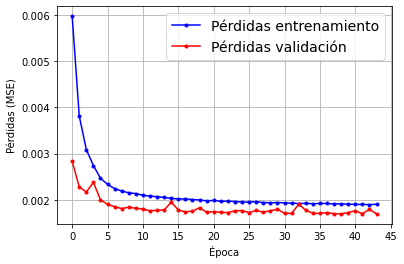

In [ ]:
# Representamos curvas pérdidas entrenamiento y validación
plot_learning_curves(history_drnn.history["loss"][1:], history_drnn.history["val_loss"][1:])
plt.show()

In [ ]:
# Cargamos los pesos del modelo que mejores pérdidas en validación nos ha dado
d_rnn_model = keras.models.load_model('best_model_drnn.h5')

In [ ]:
# Evaluamos sobre conjunto de test
deep_rnn_mse = d_rnn_model.evaluate(X_test, y_test, verbose=0)

print('MSE RNN simple: ', simp_rnn_mse)
print('MSE RNN profunda: ', deep_rnn_mse)

MSE RNN simple:  0.003814787371084094
MSE RNN profunda:  0.001713875331915915


In [ ]:
y_pred_drnn = d_rnn_model.predict(X_test)

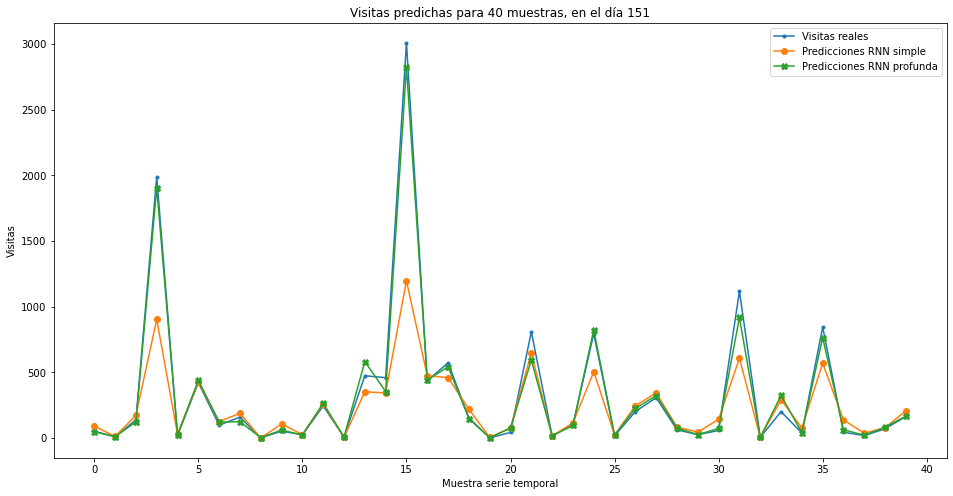

In [ ]:
plt.figure(figsize=(16,8))

num_samples = 40

# Comparamos predicciones reales de 40 registros frente a RNN simple y profunda
plt.plot(reverse_transform(y_test[0:num_samples]), '.-', label = 'Visitas reales')
plt.plot(reverse_transform(y_pred_srnn[0:num_samples]), 'o-', label = 'Predicciones RNN simple')
plt.plot(reverse_transform(y_pred_drnn[0:num_samples]), 'X-', label = 'Predicciones RNN profunda')
plt.title('Visitas predichas para ' + str(num_samples) + ' muestras, en el día ' + str(predicted_day))
plt.xlabel("Muestra serie temporal")
plt.ylabel("Visitas")
plt.legend(loc = 'best')

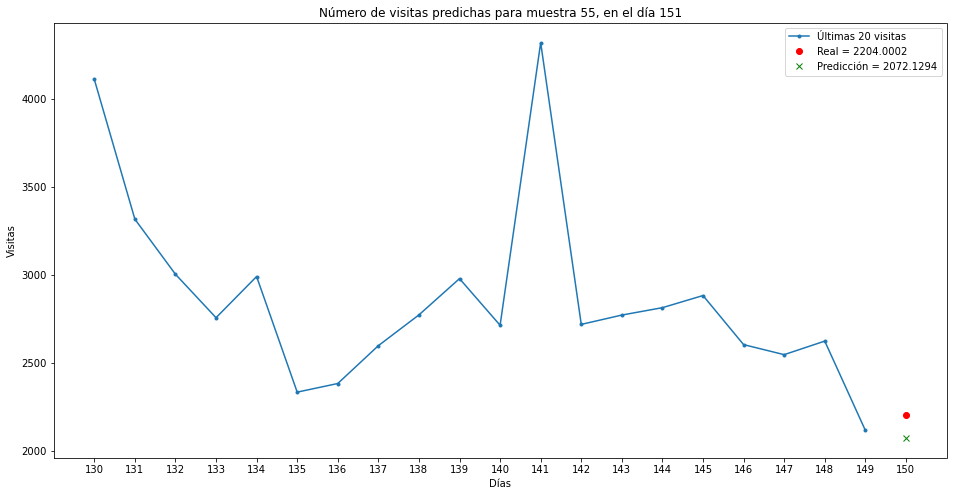

In [ ]:
# Visualizamos predicción muestra analizada set de test
sample=55
lag=20

plot_single_prediction(reverse_transform(X_test[sample, n_steps - lag : , 0]), \
                       reverse_transform(y_test[sample]), reverse_transform(y_pred_drnn[sample]), \
                       sample = sample, lag = lag, x_label = "Días", y_label = "Visitas")

En comparación con el modelo simple podemos ver menor error en la preducción (valor predicho más cercano al real).

## LSTM

La siguiente prueba que vamos a realizar es emplear bloques LSTM en lugar de RNN.

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

# Arquitectura
lstm_model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]), # Poner return_seq en las capas LSTM intermedias para pasar los valores h a la capa siguiente
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.LSTM(20),
    keras.layers.Dense(1)  
])

# Tasa de aprendizaje
optimizer = keras.optimizers.Adam(lr=0.0005)
# Compilamos

lstm_model.compile(loss="mse", optimizer=optimizer)
lstm_model.summary()

#Paramos entrenamiento si no hay mejora en validación en las últimas 5 épocas
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
# Guardamos pesos modelo que genere las menores pérdidas en validación
mc = keras.callbacks.ModelCheckpoint('best_model_lstm.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 20)          1760      
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 20)          3280      
_________________________________________________________________
lstm_2 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 8,341
Trainable params: 8,341
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_lstm = lstm_model.fit(X_train, y_train, epochs=80, batch_size=32,
                    validation_data=(X_valid, y_valid), callbacks=[early_stopping, mc])

Epoch 1/80
2188/2188 [==============================] - 207s 93ms/step - loss: 0.0114 - val_loss: 0.0025

Epoch 00001: val_loss improved from inf to 0.00253, saving model to best_model_lstm.h5
Epoch 2/80
2188/2188 [==============================] - 200s 91ms/step - loss: 0.0026 - val_loss: 0.0024

Epoch 00002: val_loss improved from 0.00253 to 0.00239, saving model to best_model_lstm.h5
Epoch 3/80
2188/2188 [==============================] - 199s 91ms/step - loss: 0.0025 - val_loss: 0.0023

Epoch 00003: val_loss improved from 0.00239 to 0.00229, saving model to best_model_lstm.h5
Epoch 4/80
2188/2188 [==============================] - 2194s 1s/step - loss: 0.0025 - val_loss: 0.0023

Epoch 00004: val_loss did not improve from 0.00229
Epoch 5/80
2188/2188 [==============================] - 718s 328ms/step - loss: 0.0024 - val_loss: 0.0022

Epoch 00005: val_loss improved from 0.00229 to 0.00219, saving model to best_model_lstm.h5
Epoch 6/80
2188/2188 [==============================] - 738

In [ ]:
lstm_model.save('lstm.h5')

In [ ]:
# Cargamos pesos de la época en la que se han obtenido menores pérdidas en validación
lstm_model = keras.models.load_model('best_model_lstm.h5')

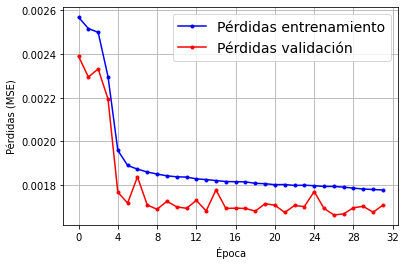

In [ ]:
# Mostramos pérdidas entrenamiento y validación
plot_learning_curves(history_lstm.history["loss"][1:], history_lstm.history["val_loss"][1:])
plt.show()

In [ ]:
# Calculamos y comparamos MSE test
lstm_mse = lstm_model.evaluate(X_test, y_test, verbose=0)
print('MSE RCNN simple: ', simp_rnn_mse)
print('MSE RCNN profunda: ', deep_rnn_mse)
print('MSE LSTM: ', lstm_mse)

MSE RCNN simple:  0.003814787371084094
MSE RCNN profunda:  0.001713875331915915
MSE LSTM:  0.001686727162450552


In [ ]:
y_pred_lstm = lstm_model.predict(X_test)

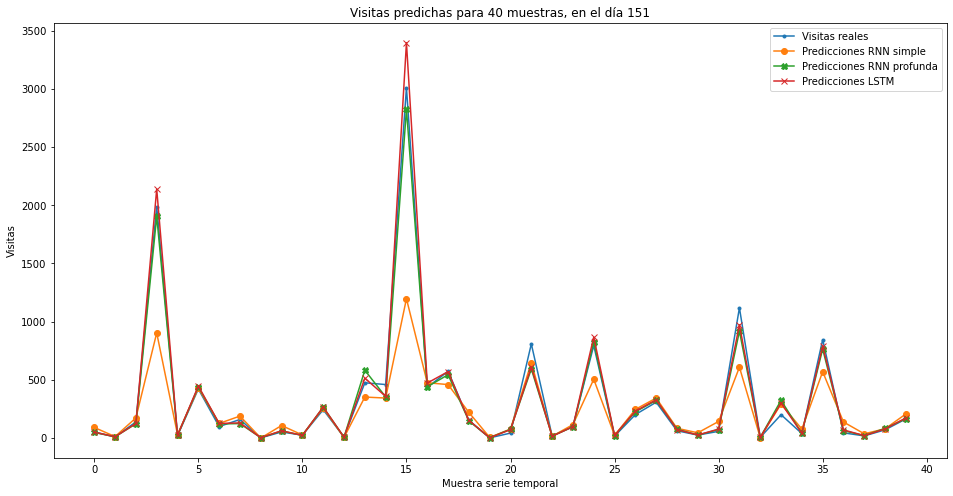

In [ ]:
plt.figure(figsize=(16,8))

num_samples = 40

# Comparamos predicciones reales de 40 registros frente a RNN simple y profunda
plt.plot(reverse_transform(y_test[0:num_samples]), '.-', label = 'Visitas reales')
plt.plot(reverse_transform(y_pred_srnn[0:num_samples]), 'o-', label = 'Predicciones RNN simple')
plt.plot(reverse_transform(y_pred_drnn[0:num_samples]), 'X-', label = 'Predicciones RNN profunda')
plt.plot(reverse_transform(y_pred_lstm[0:num_samples]), 'x-', label = 'Predicciones LSTM')
plt.title('Visitas predichas para ' + str(num_samples) + ' muestras, en el día ' + str(predicted_day))
plt.xlabel("Muestra serie temporal")
plt.ylabel("Visitas")
plt.legend(loc = 'best')

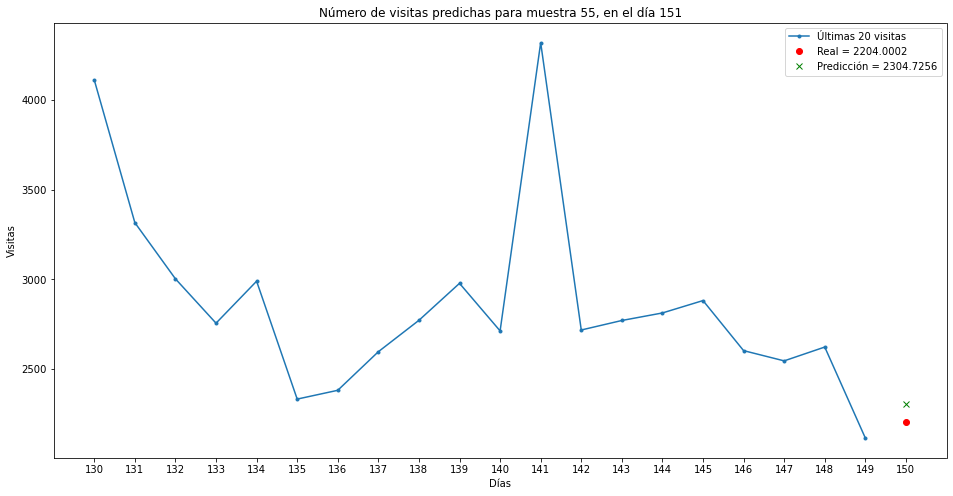

In [ ]:
sample=55
lag=20

plot_single_prediction(reverse_transform(X_test[sample, n_steps - lag : , 0]), \
                       reverse_transform(y_test[sample]), reverse_transform(y_pred_lstm[sample]), \
                       sample = sample, lag = lag, x_label = "Días", y_label = "Visitas")

### Predicción de una secuencia

Ahora vamos a tratar de predecir más de un día, concretamente 3.



In [ ]:
np.random.seed(42)

# Número instante temporales "conocidos"
n_steps = 150

# Número de días a predecir
num_days_predicted = 3

# Vamos a emplear los datos tras la trasformación logarítmica y partición (antes de escalar entre 0 y 1)
# Vamos a añadir dos registros más a las variables salida.

series = log_master_series[:, : n_steps + num_days_predicted, :]
series.shape

y_train_mult = series[:70000, -num_days_predicted:, 0]
y_valid_mult = series[70000:90000, -num_days_predicted:, 0]
y_test_mult =  series[90000:100000, -num_days_predicted:, 0]

print('Tamaño datos salida entrenamiento:', y_train_mult.shape)
print('Tamaño datos salida validación:', y_valid_mult.shape)
print('Tamaño datos salida test:', y_test_mult.shape)

Tamaño datos salida entrenamiento: (70000, 3)
Tamaño datos salida validación: (20000, 3)
Tamaño datos salida test: (10000, 3)


In [ ]:
# Escalamos las matrices generadas entre 0 y 1 
# Las matrices con los datos de entrada a la red van a ser los mismos.

# Entrenamiento
y_train_normalized = scaler.transform(y_train_mult.reshape(-1,1))
y_train_mult = y_train_normalized.reshape(y_train_mult.shape[0], y_train_mult.shape[1])

# Validación
y_valid_normalized = scaler.transform(y_valid_mult.reshape(-1,1))
y_valid_mult = y_valid_normalized.reshape(y_valid_mult.shape[0], y_valid_mult.shape[1])

# Test
y_test_normalized = scaler.transform(y_test_mult.reshape(-1,1))
y_test_mult = y_test_normalized.reshape(y_test_mult.shape[0], y_test_mult.shape[1])

print('Rango datos entrada entrenamiento:', X_train.min(), '-', X_train.max())
print('Rango datos salida entrenamiento:', y_train_mult.min(), '-', y_train_mult.max())

print('Rango datos entrada validación:', X_valid.min(), '-', X_valid.max())
print('Rango datos salida validación:', y_valid_mult.min(), '-', y_valid_mult.max())

print('Rango datos entrada test:', X_test.min(), '-', X_test.max())
print('Rango datos salida test:', y_test_mult.min(), '-', y_test_mult.max())

Rango datos entrada entrenamiento: 0.0 - 1.0
Rango datos salida entrenamiento: 0.0 - 0.99998903
Rango datos entrada validación: 0.0 - 0.9999451
Rango datos salida validación: 0.0 - 0.99976885
Rango datos entrada test: 0.0 - 0.99998903
Rango datos salida test: 0.0 - 0.999934


In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

# Arquitectura con bloques LSTM
lstm_mult_model1 = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.Dropout(rate=0.2),
    keras.layers.LSTM(20),
    keras.layers.Dense(num_days_predicted)
])

# Tasa de aprendizaje
optimizer = keras.optimizers.Adam(lr=0.0005)
# Compilamos
lstm_mult_model1.compile(loss="mse", optimizer = optimizer)

lstm_mult_model1.summary()

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = keras.callbacks.ModelCheckpoint('best_model_mult_lstm.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, None, 20)          1760      
_________________________________________________________________
lstm_4 (LSTM)                (None, None, 20)          3280      
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 20)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 63        
Total params: 8,383
Trainable params: 8,383
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_mult_lstm1 = lstm_mult_model1.fit(X_train, y_train_mult, epochs=80, batch_size=32,
                    validation_data=(X_valid, y_valid_mult), callbacks=[early_stopping, mc])

Epoch 1/80
2188/2188 [==============================] - 213s 96ms/step - loss: 0.0167 - val_loss: 0.0030

Epoch 00001: val_loss improved from inf to 0.00300, saving model to best_model_mult_lstm.h5
Epoch 2/80
2188/2188 [==============================] - 205s 94ms/step - loss: 0.0030 - val_loss: 0.0028

Epoch 00002: val_loss improved from 0.00300 to 0.00277, saving model to best_model_mult_lstm.h5
Epoch 3/80
2188/2188 [==============================] - 200s 91ms/step - loss: 0.0027 - val_loss: 0.0025

Epoch 00003: val_loss improved from 0.00277 to 0.00247, saving model to best_model_mult_lstm.h5
Epoch 4/80
2188/2188 [==============================] - 200s 91ms/step - loss: 0.0026 - val_loss: 0.0025

Epoch 00004: val_loss did not improve from 0.00247
Epoch 5/80
2188/2188 [==============================] - 214s 98ms/step - loss: 0.0026 - val_loss: 0.0026

Epoch 00005: val_loss did not improve from 0.00247
Epoch 6/80
2188/2188 [==============================] - 225s 103ms/step - loss: 0.00

In [ ]:
lstm_mult_model1.save('lstm_mult.h5')

In [ ]:
# Cargamos pesos de la época en la que se han obtenido las menores pérdidas en validación
lstm_mult_model1 = keras.models.load_model('best_model_mult_lstm.h5')

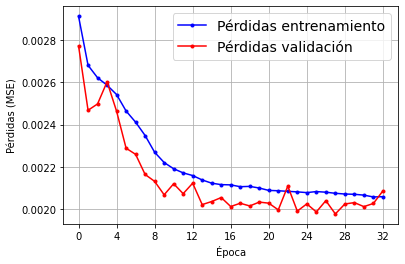

In [ ]:
# Mostramos pérdidas en entrenamiento y validación
plot_learning_curves(history_mult_lstm1.history["loss"][1:], history_mult_lstm1.history["val_loss"][1:])
plt.show()

In [ ]:
lstm_mult_model1.evaluate(X_test, y_test_mult)

313/313 [==============================] - 5s 15ms/step - loss: 0.0020


0.002014934318140149

In [ ]:
y_pred_mult_lstm = lstm_mult_model1.predict(X_test)

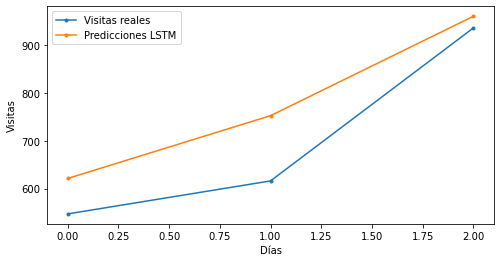

In [ ]:
sample_tested = 200

plt.figure(figsize=(8,4))

plt.plot(reverse_transform(y_test_mult[sample_tested]),  ".-", label = 'Visitas reales')
plt.plot(reverse_transform(y_pred_mult_lstm[sample_tested]),  ".-", label = 'Predicciones LSTM')

plt.xlabel("Días")
plt.ylabel("Visitas")
plt.legend(loc = 'best')

In [ ]:
# Método para mostrar predicción de múltiples instantes

def plot_multiple_predictions(series, y, y_pred, sample, lag = n_steps, num_days_predicted =3, \
                              x_label = "Instantes temporales", y_label = "Valor"):

    plt.figure(figsize=(16,8))

    plt.plot(np.arange(n_steps - lag, n_steps), series, ".-", label = 'Últimas ' + str(lag) + ' visitas')
    
    plt.plot(np.arange(n_steps, n_steps + num_days_predicted), y, "ro-", label = 'Real')
    
    plt.plot(np.arange(n_steps, n_steps + num_days_predicted),y_pred, "gx-",  label = 'Predicción LSTM')

    plt.xticks(np.arange(n_steps - lag, n_steps + num_days_predicted + 1, 1))
    
    plt.title('Visitas para la muestra ' + str(sample) + \
              ', los días ' + str(n_steps + 1) + " to "+ str(n_steps + num_days_predicted))

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(loc = 'best')

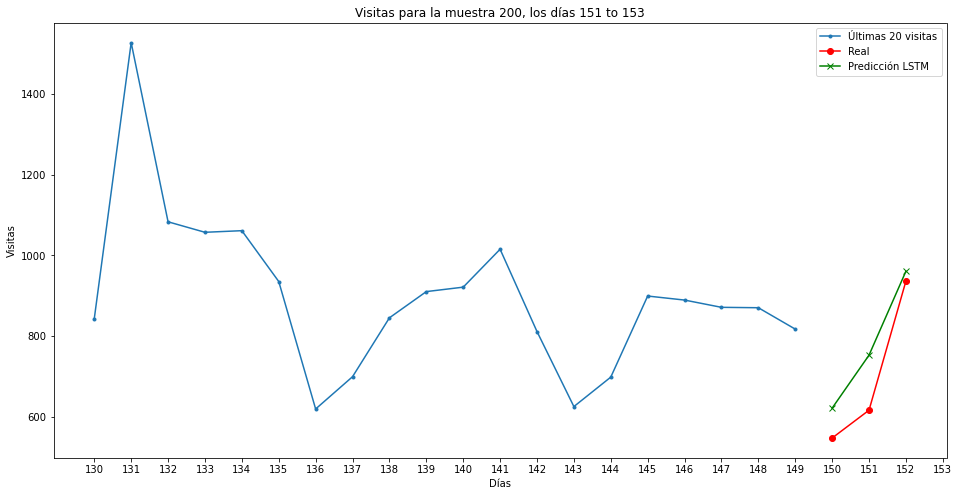

In [ ]:
lag = 20
plot_multiple_predictions(reverse_transform(X_test[sample_tested, n_steps-lag:, 0]), 
                          reverse_transform( y_test_mult[sample_tested] ),
                          reverse_transform( y_pred_mult_lstm[sample_tested] ),
                          sample=sample_tested, lag=lag, x_label = "Días", y_label = "Visitas")

# Transformers

Para adentrarnos dentro del mundo de los transformers vamos a hacer uso de la librería [Transformers](https://huggingface.co/transformers/). Esta facilita la implementación de este tipo de arquitecturas ya que dispone de modelos preentrenados que podemos emplear para adaptar a nuestras necesidades.

Con esta podemos resolver problemas de entendimiento del lenguaje natural (NLU - Natural Language Understanding) resolviendo tareas como el análisis del sentimiento de una frase, o genereción de lenguaje natural (NLG - Natural Language Generation).

Lo primero que vamos a hacer es instalar la librería:

In [1]:
!pip install transformers
# ! conda install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 8.4 MB/s 
     |████████████████████████████████| 596 kB 65.0 MB/s 
     |████████████████████████████████| 86 kB 6.2 MB/s 
     |████████████████████████████████| 6.6 MB 46.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Con la libería ya podemos resolver una serie de tareas que vienen implementadas, como son:

- Análisis del sentimiento: ¿Es el texto positivo o negativo?
- Generación de texto (en inglés): Escribir unas palabras y el modelo genera el resto (herramienta de sugerencia en Gmail)
- Reconocimiento del nombre de la entidad: en una frase etiquetar cada palabra con la entidad que representa (e.g. persona,lugar, etc.)
- Respuesta de preguntas
- Relleno de texto con huecos en blanco
- Resumen: genera un resumen de un texto largo.
- Extracción de características


Para implementar estas tareas vamos a hacer uso del método "pipeline". Este método permite llamar a una arquitectura preentrendad (BERT, GPT-2, etc ...)

https://huggingface.co/docs/transformers/v4.19.2/en/main_classes/pipelines#transformers.pipeline

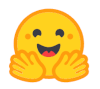

In [2]:
from transformers import pipeline
# https://www.analyticsvidhya.com/blog/2021/12/all-nlp-tasks-using-transformers-package/
# https://medium.com/geekculture/pipeline-object-in-transformers-using-hugging-face-6577f57a4c18
classifier = pipeline('sentiment-analysis')

# Lista de algunos pipelines disponibles:
# * feature-extraction (get the vector representation of a text)
# * fill-mask
# * ner (named entity recognition)
# * question-answering
# * sentiment-analysis
# * summarization
# * text-generation
# * translation
# * zero-shot-classification
# Lista completa aquí: https://huggingface.co/docs/transformers/v4.19.2/en/main_classes/pipelines#transformers.pipeline

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

In [3]:
classifier('We are very happy.')

[{'label': 'POSITIVE', 'score': 0.9998819828033447}]

In [4]:
classifier('We are very sad')

[{'label': 'NEGATIVE', 'score': 0.9989161491394043}]

Veamos si funciona en español:

In [5]:
classifier('Estamos contentos')

[{'label': 'POSITIVE', 'score': 0.9568137526512146}]

In [6]:
classifier('Estamos tristes')

[{'label': 'POSITIVE', 'score': 0.812467098236084}]

In [7]:
classifier('Estamos muy tristes')

[{'label': 'NEGATIVE', 'score': 0.9026418328285217}]

In [8]:
classifier('Estamos muy contentos')

[{'label': 'POSITIVE', 'score': 0.7560274600982666}]

Vemos que en español no funciona muy bien.

Esto nos va a pasar mucho. La mayoría de los modelos de NLP preexistentes están adaptados para resolver problemas en inglés. En español nos va a tocar trabajar un poco más para encontrarlos.

Otra opción es desarrollar un buen método de traducción del español al inglés y emplear la salida como entrada a cualquiera de estos modelos existentes.

In [9]:
!pip install keras-transformer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for keras-transformer: filename=keras_transformer-0.40.0-py3-none-any.whl size=12305 sha256=f14649683963760ab405224bad0e9c0ad29fcff9555758958bbcb2677d6523a4
  Stored in directory: /root/.cache/pip/wheels/46/68/26/692ed21edd832833c3b0a0e21615bcacd99ca458b3f9ed571f
  Created wheel for keras-embed-sim: filename=keras_embed_sim-0.10.0-py3-none-any.whl size=3960 sha256=00b5586f295d246c90bd1d4ad03b6d497e07790f7adabf7d08fa0c9e3dbfcdd3
  Stored in directory: /root/.cache/pip/wheels/81/67/b5/d847588d075895281e1cf5590f819bd4cf076a554872268bd5
  Created wheel for keras-layer-normalization: filename=keras_layer_normalization-0.16.0-py3-none-any.whl size=4668 sha256=d41c1448ad1ce34d66d4f0c70e69d3d007f9492a52601b83e79bb8a4f5d6e006
  Stored in directory: /root/.cache/pip/wheels/85/5d/1c/2e619f594f69fbcf8bc20943b27d414871c409be053994813e
  Created wheel for keras-multi-head: filename=kera

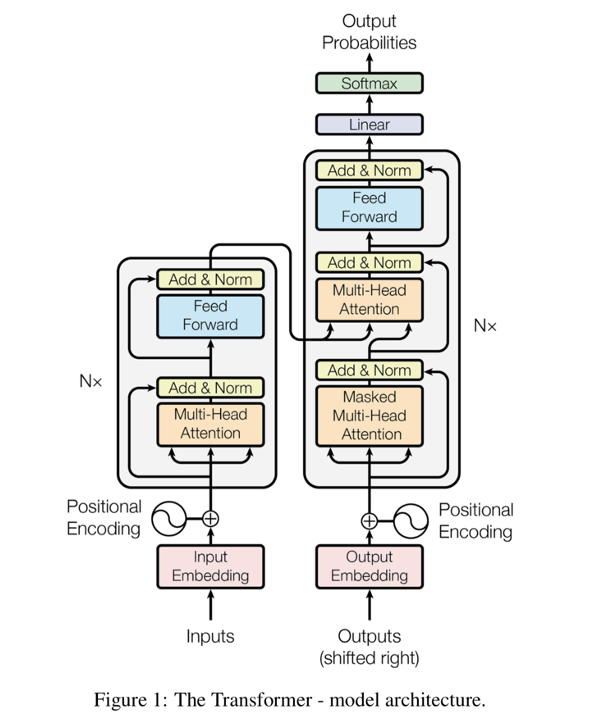

https://towardsdatascience.com/attention-is-all-you-need-e498378552f9

Los transformers sequence-to-sequence (secuencia a secuencia) están formados por un codificador y un decodificador. En el caso del traductor de español a inglés, el codificador se encargará de procesar las frases en español mientras que el decodificador se encargará de coger dicha información y generar una frase en inglés.

Para desarrollar nuestro traductor vamos a emplear una base de datos ya preparada donde tenemos numerosas frases en inglés y español.

In [10]:
# Importamos las librerías que vamos a emplear

import numpy as np
from keras_transformer import get_model, decode
from pickle import load

In [11]:
# Importamos librerías para interactuar con Google Drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [12]:
# Nos autenticamos con nuestra cuenta de Google Drive para acceder a los datos
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [13]:
# Nos descargamos los datos
download = drive.CreateFile({'id': '1ie378hV4MBwVp3_8GRspSd2RGLbBJ-bG'})
download.GetContentFile('english-spanish.pkl')

In [14]:
# Leemos la base de datos
dataset = load(open('english-spanish.pkl', 'rb'))

# Mostramos registro 120000 en ambos idiomas
print('Texto inglés:', dataset[120000,0])
print('Texto español:', dataset[120000,1])

Texto inglés: tom is a new yorker but he doesnt have a new york accent
Texto español: tom es neoyorquino pero no tiene acento de nueva york


Cuando trabajamos con texto en redes neuronales (ya sea con redes recurrentes o transformers) no podemos emplear el texto tal cual, sino que debemos de convertir dicho texto a números. Para ello, debemos de seguir una serie de pasos.

1. Dividimos las frases en palabras (tokens):

In [15]:
# Creamos "tokens"
spanish_tokens = []
for sentence in dataset[:,1]:
  spanish_tokens.append(sentence.split(' '))
print(spanish_tokens[120000])

english_tokens = []
for sentence in dataset[:,0]:
  english_tokens.append(sentence.split(' '))
print(english_tokens[120000])

['tom', 'es', 'neoyorquino', 'pero', 'no', 'tiene', 'acento', 'de', 'nueva', 'york']
['tom', 'is', 'a', 'new', 'yorker', 'but', 'he', 'doesnt', 'have', 'a', 'new', 'york', 'accent']


2. Creamos diccionario de tokens, esto es, a cada token le corresponde un número único. Además, vamos a incorporar 3 tokens especiales:
* < START >: Indica el inicio de una frase
* < END >: Indica el final de una frase
* < PAD >: Todas las frases deben de tener el mismo tamaño, por lo tanto, tras definir el tamaño máximo de frase (que se va a corresponder con la frase más larga) vamos a añadir tokens \<PAD> en aquellas frases que sean más cortas hasta alcanzar la longitud máxima. Así, por ejemplo, si el tamaño máximo son 10 palabras, y tenemos una frase de 5 palabras, a esta le añadiremos 5 tokens \<PAD>.

In [16]:
# Método para crear diccionario de tokens, esto es, número correspondiente a cada palabra
def build_token_dict(token_list):
  token_dict = {
      '<PAD>': 0,
      '<START>': 1,
      '<END>': 2
  }
  for tokens in token_list:
    for token in tokens:
      if token not in token_dict:
        token_dict[token] = len(token_dict)
  return token_dict

In [17]:
# Generamos diccionarios español e inglés
spanish_token_dict = build_token_dict(spanish_tokens)
english_token_dict = build_token_dict(english_tokens)

print(spanish_token_dict)
print(english_token_dict)

{'<PAD>': 0, '<START>': 1, '<END>': 2, 've': 3, 'vete': 4, 'vaya': 5, 'vayase': 6, 'hola': 7, 'corre': 8, 'corran': 9, 'corra': 10, 'corred': 11, 'quien': 12, 'orale': 13, 'fuego': 14, 'incendio': 15, 'disparad': 16, 'ayuda': 17, 'socorro': 18, 'auxilio': 19, 'salta': 20, 'salte': 21, 'parad': 22, 'para': 23, 'pare': 24, 'espera': 25, 'esperen': 26, 'continua': 27, 'continue': 28, 'date': 29, 'prisa': 30, 'daos': 31, 'dese': 32, 'me': 33, 'oculte': 34, 'escondi': 35, 'ocultaba': 36, 'escondia': 37, 'corri': 38, 'corria': 39, 'lo': 40, 'intento': 41, 'he': 42, 'ganado': 43, 'oh': 44, 'no': 45, 'tomatelo': 46, 'con': 47, 'soda': 48, 'disparen': 49, 'dispara': 50, 'dispare': 51, 'sonrie': 52, 'al': 53, 'ataque': 54, 'atacad': 55, 'ataquen': 56, 'ataca': 57, 'levanta': 58, 'ahora': 59, 'mismo': 60, 'id': 61, 'vayan': 62, 'ya': 63, 'tengo': 64, 'pillas': 65, 'entendiste': 66, 'el': 67, 'corrio': 68, 'metete': 69, 'adentro': 70, 'abrazame': 71, 'preocupo': 72, 'cai': 73, 'hui': 74, 'escape':

In [18]:
# Generamos diccionario inverso, es decir, de número a palabra en inglés para la salida

english_token_dict_inv = {v:k for k,v in english_token_dict.items()}
print(english_token_dict_inv)

{0: '<PAD>', 1: '<START>', 2: '<END>', 3: 'go', 4: 'hi', 5: 'run', 6: 'who', 7: 'wow', 8: 'fire', 9: 'help', 10: 'jump', 11: 'stop', 12: 'wait', 13: 'on', 14: 'hello', 15: 'hurry', 16: 'i', 17: 'hid', 18: 'ran', 19: 'try', 20: 'won', 21: 'oh', 22: 'no', 23: 'relax', 24: 'shoot', 25: 'smile', 26: 'attack', 27: 'get', 28: 'up', 29: 'now', 30: 'got', 31: 'it', 32: 'he', 33: 'hop', 34: 'in', 35: 'hug', 36: 'me', 37: 'care', 38: 'fell', 39: 'fled', 40: 'know', 41: 'left', 42: 'lied', 43: 'lost', 44: 'quit', 45: 'sang', 46: 'wept', 47: 'work', 48: 'im', 49: 'listen', 50: 'way', 51: 'really', 52: 'thanks', 53: 'we', 54: 'why', 55: 'ask', 56: 'tom', 57: 'awesome', 58: 'be', 59: 'calm', 60: 'cool', 61: 'fair', 62: 'good', 63: 'kind', 64: 'nice', 65: 'beat', 66: 'call', 67: 'us', 68: 'come', 69: 'drop', 70: 'out', 71: 'away', 72: 'home', 73: 'slow', 74: 'goodbye', 75: 'hang', 76: 'came', 77: 'hit', 78: 'hold', 79: 'agree', 80: 'bowed', 81: 'fired', 82: 'froze', 83: 'moved', 84: 'slept', 85: 'tri

In [19]:
# Vamos a añadir los tokens especiales (<START>, <END> y <PAD>) a cada frase del conjunto de datos
encoder_tokens = [['<START>'] + tokens + ['<END>'] for tokens in spanish_tokens]
decoder_tokens = [['<START>'] + tokens + ['<END>'] for tokens in english_tokens]
output_tokens = [tokens + ['<END>'] for tokens in english_tokens]

# Calculamos longitud máxima de frase
spanish_max_len = max(map(len, encoder_tokens))
english_max_len = max(map(len, decoder_tokens))

encoder_tokens = [tokens + ['<PAD>']*(spanish_max_len-len(tokens)) for tokens in encoder_tokens]
decoder_tokens = [tokens + ['<PAD>']*(english_max_len-len(tokens)) for tokens in decoder_tokens]
output_tokens = [tokens + ['<PAD>']*(english_max_len-len(tokens)) for tokens in output_tokens ]

In [20]:
print(encoder_tokens[120000])
print(decoder_tokens[120000])
print(output_tokens[120000])

['<START>', 'tom', 'es', 'neoyorquino', 'pero', 'no', 'tiene', 'acento', 'de', 'nueva', 'york', '<END>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
['<START>', 'tom', 'is', 'a', 'new', 'yorker', 'but', 'he', 'doesnt', 'have', 'a', 'new', 'york', 'accent', '<END>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
['tom', 'is', 'a', 'new', 'yorker', 'but', 'he', 'doesnt', 'have', 'a', 'new', 'york', 'accent', '<END>', '<PAD>', '<PAD>

https://miro.medium.com/max/1400/1*HDqn93FsA93o2z4bTwqUVQ.gif

3. Convertimos tokens a números

In [21]:
encoder_input = [list(map(lambda x: spanish_token_dict[x], tokens)) for tokens in encoder_tokens]
decoder_input = [list(map(lambda x: english_token_dict[x], tokens)) for tokens in decoder_tokens]
output_decoded = [list(map(lambda x: [english_token_dict[x]], tokens)) for tokens in output_tokens]

print(encoder_input[120000])
print(decoder_input[120000])
print(output_decoded[120000])

[1, 123, 387, 23929, 1210, 45, 1006, 8223, 98, 1233, 10238, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 56, 258, 120, 197, 12666, 2914, 32, 1577, 140, 120, 197, 5385, 4287, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[[56], [258], [120], [197], [12666], [2914], [32], [1577], [140], [120], [197], [5385], [4287], [2], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0]]


En este punto ya tenemos los datos listos. Vamos a entrenar el transformer

In [23]:
# Creamos modelo
model = get_model(
    token_num = max(len(spanish_token_dict),len(english_token_dict)), # tamaño del corpus
    embed_dim = 32,
    encoder_num = 2,
    decoder_num = 2,
    head_num = 4,
    hidden_dim = 128,
    dropout_rate = 0.05,
    use_same_embed = False,
)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Encoder-Input (InputLayer)     [(None, None)]       0           []                               
                                                                                                  
 Encoder-Token-Embedding (Embed  [(None, None, 32),  808608      ['Encoder-Input[0][0]']          
 dingRet)                        (25269, 32)]                                                     
                                                                                                  
 Encoder-Embedding (TrigPosEmbe  (None, None, 32)    0           ['Encoder-Token-Embedding[0][0]']
 dding)                                                                                           
                                                                                              

In [ ]:
# Entrenamiento
# 30 minutos con GPU en Colab
model.fit(
    x=[np.array(encoder_input), np.array(decoder_input)],
    y=np.array(output_decoded),
    epochs=15,
    batch_size=32,
    verbose=1
)

Epoch 1/15
3886/3886 [==============================] - 134s 32ms/step - loss: 0.6269
Epoch 2/15
3886/3886 [==============================] - 123s 32ms/step - loss: 0.3771
Epoch 3/15
3886/3886 [==============================] - 121s 31ms/step - loss: 0.2974
Epoch 4/15
3886/3886 [==============================] - 120s 31ms/step - loss: 0.2560
Epoch 5/15
3886/3886 [==============================] - 121s 31ms/step - loss: 0.2304
Epoch 6/15
3886/3886 [==============================] - 119s 31ms/step - loss: 0.2130
Epoch 7/15
2389/3886 [=================>............] - ETA: 46s - loss: 0.1977

In [ ]:
model.save('translator.h5')

Ahora vamos a emplear el modelo entrenado para realizar inferencia, esto es, traducir un texto de español a inglés.

In [ ]:
model.load_weights('translator.h5')

In [ ]:
# Método para traducir una frase
def translate(sentence):
  sentence_tokens = [tokens + ['<END>'] for tokens in [sentence.split(' ')]]
  print("sentence_tokens: ", sentence_tokens)
  tr_input = [list(map(lambda x: spanish_token_dict[x], tokens)) for tokens in sentence_tokens][0]
  print("tr_input: ", tr_input)
  decoded = decode(
      model, 
      tr_input, 
      start_token = english_token_dict['<START>'],
      end_token = english_token_dict['<END>'],
      pad_token = english_token_dict['<PAD>']
  )

  print("decoded: ", decoded)

  translation = ' '.join(map(lambda x: english_token_dict_inv[x], decoded[1:-1]))

  print('Frase original: {}'.format(sentence))
  print('Traducción: {}'.format(translation))
  
  return translation

In [ ]:
translation = translate('estamos tristes')

sentence_tokens:  [['estamos', 'tristes', '<END>']]
tr_input:  [453, 4567, 2]
decoded:  [1, 229, 200, 2]
Frase original: estamos tristes
Traducción: were sad


In [ ]:
classifier('estamos tristes')

In [ ]:
classifier(translation)

[{'label': 'NEGATIVE', 'score': 0.998762845993042}]

## Vision Transformers (ViT)



Procesan las imágenes como una secuencia de pedazos en los que se incluye información posicional, como ocurre en los transformers usados para NLP.

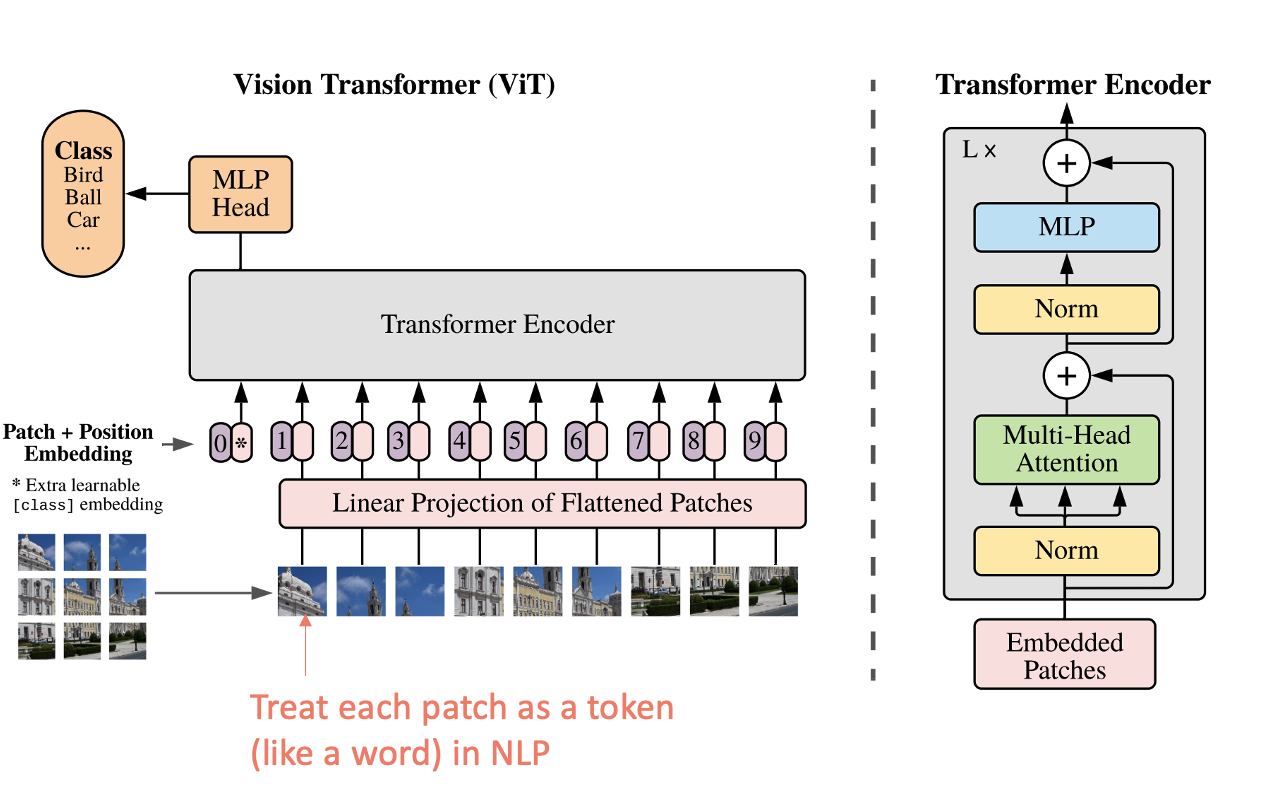

Los transformers guardan más información posicional de los elementos que las redes convolucionales

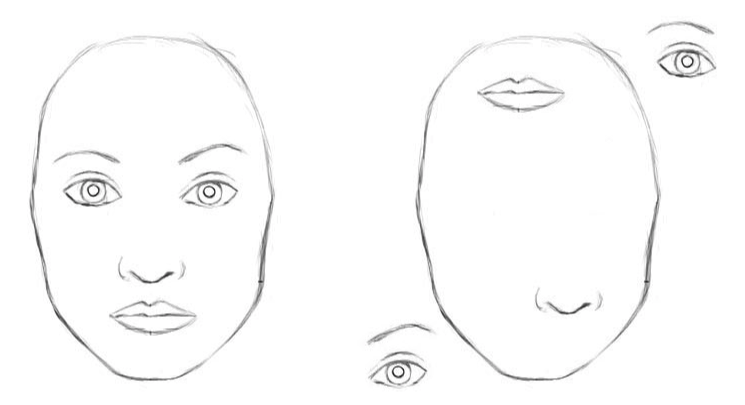

## Clasificación de imágenes con sólo 2 líneas de código

https://gradio.app/image_classification_with_vision_transformers/

In [ ]:
!pip install gradio

In [ ]:
import gradio as gr

gr.Interface.load(
             "huggingface/google/vit-base-patch16-224",
             examples=["alligator.jpg", "laptop.jpg"]).launch()

Fetching model from: https://huggingface.co/google/vit-base-patch16-224
Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://28107.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


(<fastapi.applications.FastAPI at 0x7fb9bbd23d50>,
 'http://127.0.0.1:7860/',
 'https://28107.gradio.app')